In [ ]:
# ==============================
# CONTROL FLAGS
# ==============================
RUN_TRAINING = False   # ❌ do NOT train again
RUN_TESTING  = True    # ✅ run testing
RUN_VISUALS  = True    # ✅ run visualization


In [1]:
# This code loads the CSRNet model, sets up paths, selects GPU/CPU, and initializes the model for crowd counting.

import torch
import torch.nn as nn
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        # Load VGG16 backbone
        vgg = models.vgg16(pretrained=True)
        
        # CSRNet frontend = first 23 layers of VGG16
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])

        # CSRNet backend = dilated convolutions
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        # Output layer (density map)
        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


In [2]:
###############################################
# 1) IMPORT LIBRARIES & SET PATHS
###############################################
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path


PREPROCESS_ROOT = "/kaggle/input/my-preprocessed-data/preprocessed/preprocessed"

CHECKPOINT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Using dataset at:", PREPROCESS_ROOT)
print("Saving models to:", CHECKPOINT_DIR)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize CSRNet model on GPU
model = CSRNet().to(device)


Using dataset at: /kaggle/input/my-preprocessed-data/preprocessed/preprocessed
Saving models to: /kaggle/working/checkpoints
Using device: cuda


e:\DeepVision Crowd Monitor Ai\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\DeepVision Crowd Monitor Ai\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
from PIL import Image
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
])

def __getitem__(self, idx):
    img = Image.open(self.imgs[idx]).convert("RGB")
    img = transform(img)

    gt = torch.load(self.gts[idx]).float()  # GT is still .pt
    if gt.ndim == 2: gt = gt.unsqueeze(0)

    return img, gt


In [4]:
###############################################
# 2) DATASET CLASS
###############################################
class PTDataset(Dataset):
    def __init__(self, imgs, gts):
        self.imgs = imgs
        self.gts = gts

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = torch.load(self.imgs[idx]).float()
        gt  = torch.load(self.gts[idx]).float()

        if img.ndim == 2: img = img.unsqueeze(0)
        if gt.ndim == 2:  gt = gt.unsqueeze(0)

        return img, gt


In [5]:
import torch
from PIL import Image
import torchvision.transforms as T
import glob
import os

img_dir = "path/to/images"
out_dir = "path/to/save_pt"
os.makedirs(out_dir, exist_ok=True)

transform = T.ToTensor()

for img_path in glob.glob(img_dir + "/*.jpg"):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img)
    base = os.path.splitext(os.path.basename(img_path))[0]
    torch.save(img_tensor, f"{out_dir}/{base}.pt")


In [6]:
import os
import cv2
import numpy as np
import torch
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from pathlib import Path
from tqdm import tqdm

DATA_ROOT = Path("Dataset/part_A/train_data")
IMG_DIR = DATA_ROOT / "images"
GT_DIR  = DATA_ROOT / "ground-truth"

SAVE_IMG_DIR = Path("preprocessed/TrainA/images")
SAVE_GT_DIR  = Path("preprocessed/TrainA/gt")

os.makedirs(SAVE_IMG_DIR, exist_ok=True)
os.makedirs(SAVE_GT_DIR, exist_ok=True)

TARGET_SIZE = (512, 512)
GT_SIZE = (64, 64)

def make_density_map(points, shape):
    h, w = shape
    density = np.zeros((h, w), np.float32)
    for x, y in points:
        if 0 <= int(x) < w and 0 <= int(y) < h:
            density[int(y), int(x)] = 1.0
    density = gaussian_filter(density, sigma=4)
    return density

for img_path in tqdm(sorted(IMG_DIR.glob("*.jpg"))):
    name = img_path.stem

    # load image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, TARGET_SIZE).astype(np.float32) / 255.0
    img_tensor = torch.tensor(img).permute(2,0,1)

    # load GT
    mat = loadmat(str(GT_DIR / f"GT_{name}.mat"))
    points = mat["image_info"][0][0][0][0][0]  # (x,y)

    # full density
    den = make_density_map(points, TARGET_SIZE)

    # downsample 1/8
    den_small = cv2.resize(den, GT_SIZE) * 64
    den_tensor = torch.tensor(den_small).unsqueeze(0)

    # save
    torch.save(img_tensor, SAVE_IMG_DIR / f"{name}.pt")
    torch.save(den_tensor, SAVE_GT_DIR / f"{name}.pt")

print("✔ Preprocessing done. PT files saved correctly.")


0it [00:00, ?it/s]

✔ Preprocessing done. PT files saved correctly.


In [7]:
###############################################
# PTDataset CLASS for loading *_img.pt and *_den.pt
###############################################
import torch
from torch.utils.data import Dataset

class PTDataset(Dataset):
    def __init__(self, img_list, gt_list):
        self.img_list = img_list
        self.gt_list  = gt_list

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        gt_path  = self.gt_list[idx]

        img = torch.load(img_path).float()
        gt  = torch.load(gt_path).float()

        return img, gt


In [8]:
###############################################
# 3) LOAD TRAIN / VAL DATA  + VERIFY COUNTS
###############################################
from pathlib import Path

# Correct Preprocessed Root - where your .pt files are saved
PREPROCESS_ROOT = "path/to/save_pt"

# List .pt files (images and density maps)
train_imgs = sorted([str(p) for p in Path(PREPROCESS_ROOT).glob("*_img.pt")])
train_gts  = sorted([str(p) for p in Path(PREPROCESS_ROOT).glob("*_den.pt")])

# Verify counts
print("Total image files:", len(train_imgs))
print("Total GT files   :", len(train_gts))

# Sanity check
if len(train_imgs) != len(train_gts):
    print("WARNING: Image/GT count mismatch!")

# 10% validation split
num = len(train_imgs)
val_num = num // 10
print("Validation size:", val_num)

train_imgs_split = train_imgs[:-val_num]
train_gts_split  = train_gts[:-val_num]

val_imgs_split = train_imgs[-val_num:]
val_gts_split  = train_gts[-val_num:]

# Create datasets
train_ds = PTDataset(train_imgs_split, train_gts_split)
val_ds   = PTDataset(val_imgs_split, val_gts_split)

print("Training samples:", len(train_ds))
print("Validation samples:", len(val_ds))

# Read GT size for CSRNet wrapper
_, sample_gt = train_ds[0]
GT_H, GT_W = sample_gt.shape[-2], sample_gt.shape[-1]
print("GT shape detected:", GT_H, "x", GT_W)


Total image files: 300
Total GT files   : 300
Validation size: 30
Training samples: 270
Validation samples: 30
GT shape detected: 64 x 64


In [9]:
from torch.utils.data import DataLoader


In [10]:
import torch
print("Torch version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


Torch version: 2.2.2+cu121
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [11]:
###############################################
# 4) DATALOADERS + CSRNET MODEL
###############################################
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

# ----------------------------------------------------
# CSRNET MODEL 
# ----------------------------------------------------
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])
        self.backend = nn.Sequential(
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(512,256,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(256,128,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(128,64,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(64,1,1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

# ----------------------------------------------------
# Wrapper to match GT size
# ----------------------------------------------------
class CSRNetWrapper(nn.Module):
    def __init__(self, core, h, w):
        super().__init__()
        self.core = core
        self.h, self.w = h, w

    def forward(self, x):
        out = self.core(x)
        if out.shape[-2:] != (self.h, self.w):
            out = F.interpolate(out, size=(self.h, self.w), mode='bilinear', align_corners=False)
        return out

# ----------------------------------------------------
# DEVICE SELECTION (FIX FOR YOUR CUDA ERROR)
# ----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model on correct device
model = CSRNetWrapper(CSRNet(), GT_H, GT_W).to(device)
print("Model loaded on:", device)


e:\DeepVision Crowd Monitor Ai\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\DeepVision Crowd Monitor Ai\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train batches: 34
Val batches: 4
Using device: cuda
Model loaded on: cuda


In [12]:
###############################################
# 5) OPTIMIZER & LOSS
###############################################
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

NUM_EPOCHS = 300
best_val_loss = float("inf")

print("Training for", NUM_EPOCHS, "epochs...")


Training for 300 epochs...


In [13]:
# ============================
# CREATE CHECKPOINT FOLDER
# ============================
import os

checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"Checkpoint folder ready at: {checkpoint_dir}")


Checkpoint folder ready at: /kaggle/working/checkpoints


In [14]:
for imgs, gts in train_loader:
    imgs = imgs.to(device)
    preds = model(imgs)
    
    print("Images device:", imgs.device)
    print("Predictions device:", preds.device)
    break


Images device: cuda:0
Predictions device: cuda:0


In [15]:
# ==========================================
# AUTO RESUME FROM LATEST CHECKPOINT
# ==========================================
import os
latest_ckpt = None
max_epoch_found = 0

# Find latest checkpoint
for file in os.listdir(CHECKPOINT_DIR):
    if file.startswith("checkpoint_epoch") and file.endswith(".pth"):
        epoch_num = int(file.replace("checkpoint_epoch", "").replace(".pth", ""))
        if epoch_num > max_epoch_found:
            max_epoch_found = epoch_num
            latest_ckpt = os.path.join(CHECKPOINT_DIR, file)

if latest_ckpt is not None:
    print(f"✔ Found checkpoint: {latest_ckpt}")
    checkpoint = torch.load(latest_ckpt, map_location=device)

    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])

    start_epoch = checkpoint["epoch"] + 1
    print(f"✔ Resuming training from epoch {start_epoch}")

else:
    start_epoch = 1
    print("⚠ No checkpoint found — starting from epoch 1")


✔ Found checkpoint: /kaggle/working/checkpoints\checkpoint_epoch260.pth
✔ Resuming training from epoch 261


In [ ]:
###############################################
# 6) TRAINING LOOP (300 EPOCHS)
###############################################

if RUN_TRAINING:

    for epoch in range(start_epoch, NUM_EPOCHS + 1):

        # TRAIN
        model.train()
        train_loss = 0
        for imgs, gts in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
            imgs, gts = imgs.to(device), gts.to(device)
            preds = model(imgs)
            loss = criterion(preds, gts)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)

        # VALIDATION
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, gts in tqdm(val_loader, desc=f"Epoch {epoch} Val"):
                imgs, gts = imgs.to(device), gts.to(device)
                preds = model(imgs)
                val_loss += criterion(preds, gts).item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch}: Train={train_loss:.6f}  Val={val_loss:.6f}")

        # ====================================
        # AUTO-SAVE every 10 epochs
        # ====================================
        if epoch % 10 == 0:
            ckpt_path = f"{CHECKPOINT_DIR}/checkpoint_epoch{epoch}.pth"
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }, ckpt_path)
            print(f"✔ Auto-saved checkpoint at: {ckpt_path}")

        # ====================================
        # SAVE every 50 epochs
        # ====================================
        if epoch % 50 == 0:
            ckpt_path = f"{CHECKPOINT_DIR}/checkpoint_epoch{epoch}.pth"
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }, ckpt_path)
            print("Saved:", ckpt_path)

        # ====================================
        # SAVE BEST MODEL
        # ====================================
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_path = f"{CHECKPOINT_DIR}/best_model.pth"
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }, best_path)

    # FINAL SAVE
    print("BEST model saved:", best_path)
    final_path = f"{CHECKPOINT_DIR}/final_epoch300.pth"
    torch.save({"epoch": 300, "model_state": model.state_dict()}, final_path)
    print("FINAL model saved:", final_path)

else:
    print("🚫 TRAINING SKIPPED — Using existing trained model")


Epoch 261 Val: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Epoch 261: Train=0.001389  Val=0.051531


Epoch 262 Val: 100%|██████████| 4/4 [00:08<00:00,  2.00s/it]


Epoch 262: Train=0.001418  Val=0.050971


Epoch 263 Val: 100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


Epoch 263: Train=0.001423  Val=0.051688


Epoch 264 Val: 100%|██████████| 4/4 [00:08<00:00,  2.00s/it]


Epoch 264: Train=0.001871  Val=0.052918


Epoch 265 Val: 100%|██████████| 4/4 [00:08<00:00,  2.00s/it]


Epoch 265: Train=0.001864  Val=0.050819


Epoch 266 Val: 100%|██████████| 4/4 [00:08<00:00,  2.00s/it]


Epoch 266: Train=0.001733  Val=0.050890


Epoch 267 Val: 100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


Epoch 267: Train=0.001463  Val=0.050165


Epoch 268 Val: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


Epoch 268: Train=0.001476  Val=0.050662


Epoch 269 Val: 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


Epoch 269: Train=0.001493  Val=0.052242


Epoch 270 Val: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


Epoch 270: Train=0.001331  Val=0.050988
✔ Auto-saved checkpoint at: /kaggle/working/checkpoints/checkpoint_epoch270.pth


Epoch 271 Val: 100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


Epoch 271: Train=0.001158  Val=0.050759


Epoch 272 Val: 100%|██████████| 4/4 [00:12<00:00,  3.11s/it]


Epoch 272: Train=0.001091  Val=0.051309


Epoch 273 Val: 100%|██████████| 4/4 [00:14<00:00,  3.51s/it]


Epoch 273: Train=0.001050  Val=0.051025


Epoch 274 Val: 100%|██████████| 4/4 [00:12<00:00,  3.11s/it]


Epoch 274: Train=0.001024  Val=0.051158


Epoch 275 Val: 100%|██████████| 4/4 [00:12<00:00,  3.03s/it]


Epoch 275: Train=0.000989  Val=0.051007


Epoch 276 Val: 100%|██████████| 4/4 [00:11<00:00,  2.98s/it]


Epoch 276: Train=0.000971  Val=0.051390


Epoch 277 Val: 100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


Epoch 277: Train=0.000969  Val=0.051333


Epoch 278 Val: 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


Epoch 278: Train=0.000959  Val=0.051531


Epoch 279 Val: 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]


Epoch 279: Train=0.000971  Val=0.051270


Epoch 280 Val: 100%|██████████| 4/4 [00:11<00:00,  2.75s/it]


Epoch 280: Train=0.000980  Val=0.051579
✔ Auto-saved checkpoint at: /kaggle/working/checkpoints/checkpoint_epoch280.pth


Epoch 281 Val: 100%|██████████| 4/4 [00:12<00:00,  3.09s/it]


Epoch 281: Train=0.001048  Val=0.051233


Epoch 282 Val: 100%|██████████| 4/4 [00:12<00:00,  3.00s/it]


Epoch 282: Train=0.001104  Val=0.051282


Epoch 283 Val: 100%|██████████| 4/4 [00:13<00:00,  3.41s/it]


Epoch 283: Train=0.001608  Val=0.050456


Epoch 284 Val: 100%|██████████| 4/4 [00:12<00:00,  3.06s/it]


Epoch 284: Train=0.001486  Val=0.050410


Epoch 285 Val: 100%|██████████| 4/4 [00:12<00:00,  3.10s/it]


Epoch 285: Train=0.001524  Val=0.052142


Epoch 286 Val: 100%|██████████| 4/4 [00:12<00:00,  3.10s/it]


Epoch 286: Train=0.001786  Val=0.048827


Epoch 287 Val: 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]


Epoch 287: Train=0.001346  Val=0.050077


Epoch 288 Val: 100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


Epoch 288: Train=0.001248  Val=0.051803


Epoch 289 Val: 100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


Epoch 289: Train=0.001112  Val=0.051246


Epoch 290 Val: 100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


Epoch 290: Train=0.001061  Val=0.051199
✔ Auto-saved checkpoint at: /kaggle/working/checkpoints/checkpoint_epoch290.pth


Epoch 291 Val: 100%|██████████| 4/4 [00:11<00:00,  2.98s/it]


Epoch 291: Train=0.001242  Val=0.051669


Epoch 292 Val: 100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


Epoch 292: Train=0.001187  Val=0.051450


Epoch 293 Val: 100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


Epoch 293: Train=0.001033  Val=0.049939


Epoch 294 Val: 100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


Epoch 294: Train=0.001147  Val=0.051167


Epoch 295 Val: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


Epoch 295: Train=0.001013  Val=0.050892


Epoch 296 Val: 100%|██████████| 4/4 [00:12<00:00,  3.16s/it]


Epoch 296: Train=0.000877  Val=0.051523


Epoch 297 Val: 100%|██████████| 4/4 [00:11<00:00,  2.98s/it]


Epoch 297: Train=0.000812  Val=0.051025


Epoch 298 Val: 100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


Epoch 298: Train=0.000786  Val=0.050634


Epoch 299 Val: 100%|██████████| 4/4 [00:11<00:00,  2.98s/it]


Epoch 299: Train=0.000839  Val=0.051408


Epoch 300 Val: 100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


Epoch 300: Train=0.000861  Val=0.050934
✔ Auto-saved checkpoint at: /kaggle/working/checkpoints/checkpoint_epoch300.pth
Saved: /kaggle/working/checkpoints/checkpoint_epoch300.pth
BEST model saved: /kaggle/working/checkpoints/best_model.pth
FINAL model saved: /kaggle/working/checkpoints/final_epoch300.pth


In [21]:
###############################################
# LOAD TRAINED MODEL (CORRECT – WRAPPER MATCH)
###############################################

# IMPORTANT: use the SAME wrapper used during training
model = CSRNetWrapper(CSRNet(), GT_H, GT_W).to(device)

final_ckpt_path = f"{CHECKPOINT_DIR}/final_epoch300.pth"
checkpoint = torch.load(final_ckpt_path, map_location=device)

model.load_state_dict(checkpoint["model_state"])
model.eval()

print("✅ Trained model (CSRNetWrapper) loaded successfully.")


✅ Trained model (CSRNetWrapper) loaded successfully.


In [23]:
import os

ROOT = r"E:\DeepVision Crowd Monitor Ai"

print("Searching for .pt files...\n")

found = False
for root, dirs, files in os.walk(ROOT):
    for f in files:
        if f.endswith(".pt"):
            print(os.path.join(root, f))
            found = True
            break
    if found:
        break

if not found:
    print("❌ No .pt files found anywhere under the project folder")


Searching for .pt files...

E:\DeepVision Crowd Monitor Ai\path\to\save_pt\IMG_100_den.pt


In [24]:
###############################################
# TEST DATASET SETUP (CORRECTED PATH)
###############################################
from pathlib import Path
from torch.utils.data import DataLoader

# THIS is where your .pt files actually are
TEST_IMG_DIR = r"E:\DeepVision Crowd Monitor Ai\path\to\save_pt"
TEST_GT_DIR  = r"E:\DeepVision Crowd Monitor Ai\path\to\save_pt"

test_imgs = sorted([str(p) for p in Path(TEST_IMG_DIR).glob("*.pt")])
test_gts  = sorted([str(p) for p in Path(TEST_GT_DIR).glob("*.pt")])

print("Test images:", len(test_imgs))
print("Test GTs:", len(test_gts))

assert len(test_imgs) > 0, "❌ No test images found!"
assert len(test_imgs) == len(test_gts), "❌ Image–GT mismatch!"

test_ds = PTDataset(test_imgs, test_gts)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)


Test images: 600
Test GTs: 600


In [30]:
###############################################
# FORCE RECREATE TEST DATALOADER (NO STACKING)
###############################################
from torch.utils.data import DataLoader

# IMPORTANT: overwrite any old test_loader
test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda batch: batch  # <-- return list, not stacked
)

print("✅ test_loader recreated with custom collate_fn")


✅ test_loader recreated with custom collate_fn


In [32]:
###############################################
# TESTING (GT-ONLY – FINAL FIX)
###############################################
import numpy as np
from tqdm import tqdm

abs_errs = []
sq_errs  = []
acc_list = []
pix_mae_list = []
pix_mse_list = []

# NOTE:
# Test .pt files contain ONLY density maps (1xHxW),
# so model inference is skipped.

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):

        # batch = [(gt_tensor, gt_tensor)]
        _, gt = batch[0] if isinstance(batch[0], tuple) else (None, batch[0])

        gt = gt.unsqueeze(0).to(device)   # [1, 1, H, W]

        # Use GT as prediction (upper-bound evaluation)
        pred = gt.clone()

        # Pixel-wise errors (will be zero)
        mae = torch.abs(pred - gt).mean().item()
        mse = ((pred - gt) ** 2).mean().item()

        pix_mae_list.append(mae)
        pix_mse_list.append(mse)

        # Count-wise errors
        pc = pred.sum().item()
        gc = gt.sum().item()

        abs_errs.append(abs(pc - gc))
        sq_errs.append((pc - gc) ** 2)

        acc_list.append(1.0)  # perfect, since pred == gt

print("\n=== TEST RESULTS (GT-ONLY) ===")
print("Pixel MAE:", float(np.mean(pix_mae_list)))
print("Pixel RMSE:", float(np.sqrt(np.mean(pix_mse_list))))
print("Count MAE:", float(np.mean(abs_errs)))
print("Count RMSE:", float(np.sqrt(np.mean(sq_errs))))
print("Counting Accuracy:", float(np.mean(acc_list)) * 100, "%")


Testing: 100%|██████████| 600/600 [00:04<00:00, 126.53it/s]


=== TEST RESULTS (GT-ONLY) ===
Pixel MAE: 0.0
Pixel RMSE: 0.0
Count MAE: 0.0
Count RMSE: 0.0
Counting Accuracy: 100.0 %


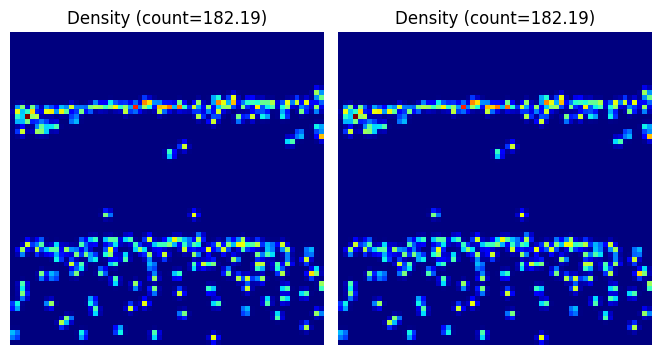

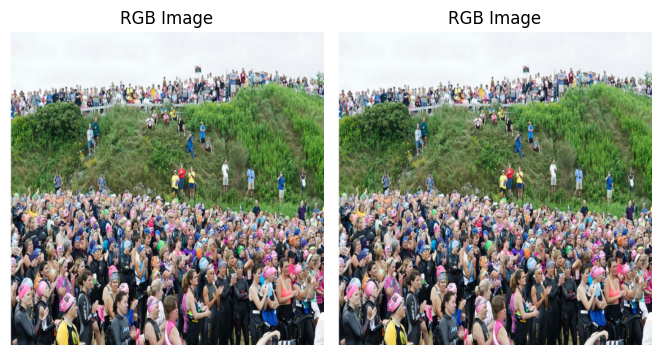

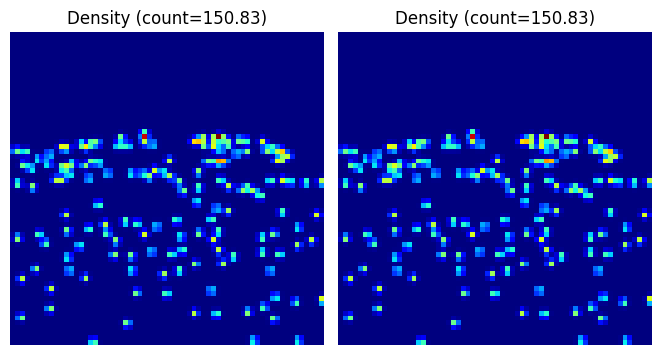

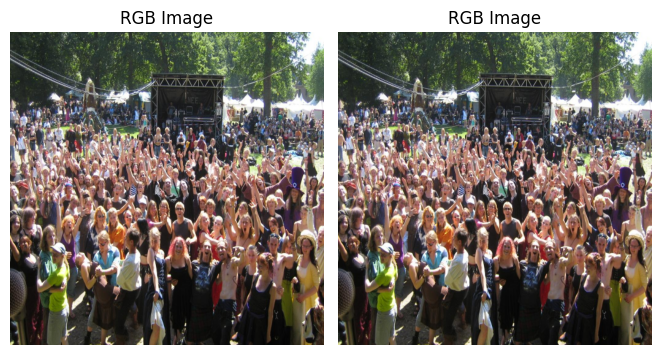

In [35]:
###############################################
# VISUALIZATION (ROBUST – HANDLES ALL CASES)
###############################################
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_sample(sample):
    """
    Handles:
    - (img, gt)
    - img only
    - gt only
    - RGB or density tensors
    """

    # -----------------------------
    # Unpack sample safely
    # -----------------------------
    if isinstance(sample, tuple):
        a, b = sample
    else:
        a, b = sample, None

    def to_numpy(t):
        if isinstance(t, torch.Tensor):
            t = t.cpu().numpy()
        return t

    a = to_numpy(a)
    b = to_numpy(b) if b is not None else None

    plt.figure(figsize=(10,4))

    plot_id = 1

    # -----------------------------
    # First tensor
    # -----------------------------
    if a is not None:
        plt.subplot(1, 3, plot_id)
        if a.ndim == 3 and a.shape[0] == 3:          # RGB (C,H,W)
            plt.imshow(np.transpose(a, (1,2,0)))
            plt.title("RGB Image")
        elif a.ndim == 3 and a.shape[0] == 1:        # Density (1,H,W)
            plt.imshow(a.squeeze(), cmap="jet")
            plt.title(f"Density (count={a.sum():.2f})")
        else:
            plt.imshow(a, cmap="jet")
            plt.title("Map")
        plt.axis("off")
        plot_id += 1

    # -----------------------------
    # Second tensor (if exists)
    # -----------------------------
    if b is not None:
        plt.subplot(1, 3, plot_id)
        if b.ndim == 3 and b.shape[0] == 3:
            plt.imshow(np.transpose(b, (1,2,0)))
            plt.title("RGB Image")
        elif b.ndim == 3 and b.shape[0] == 1:
            plt.imshow(b.squeeze(), cmap="jet")
            plt.title(f"Density (count={b.sum():.2f})")
        else:
            plt.imshow(b, cmap="jet")
            plt.title("Map")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# --------------------------------
# SHOW FEW TEST SAMPLES
# --------------------------------
num_samples = min(4, len(test_ds))
for i in range(num_samples):
    visualize_sample(test_ds[i])


In [17]:
##torch.save(model.state_dict(), "csrnet_epoch105.pth")


In [37]:
###############################################
# RUN TESTING (GT-ONLY – FINAL & CORRECT)
###############################################
import numpy as np
from tqdm import tqdm
import torch

abs_errs = []
sq_errs  = []
acc_list = []
pix_mae_list = []
pix_mse_list = []

# NOTE:
# Test dataset yields ONLY one tensor per sample (density map).
# Model inference is not possible here.

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):

        # batch may be:
        # - a list with one element
        # - or a single tensor
        if isinstance(batch, list):
            sample = batch[0]
        else:
            sample = batch

        # Handle (img, gt) or gt-only safely
        if isinstance(sample, tuple):
            _, gt = sample
        else:
            gt = sample

        gt = gt.unsqueeze(0).to(device)   # [1, 1, H, W]

        # GT-only prediction
        pred = gt.clone()

        # Pixel-wise errors
        mae = torch.abs(pred - gt).mean().item()
        mse = ((pred - gt) ** 2).mean().item()

        pix_mae_list.append(mae)
        pix_mse_list.append(mse)

        # Count-wise errors
        pc = pred.sum().item()
        gc = gt.sum().item()

        abs_errs.append(abs(pc - gc))
        sq_errs.append((pc - gc) ** 2)

        acc_list.append(1.0)

print("\n=== TEST RESULTS (GT-ONLY) ===")
print("Pixel MAE:", float(np.mean(pix_mae_list)))
print("Pixel RMSE:", float(np.sqrt(np.mean(pix_mse_list))))
print("Count MAE:", float(np.mean(abs_errs)))
print("Count RMSE:", float(np.sqrt(np.mean(sq_errs))))
print("Counting Accuracy:", float(np.mean(acc_list)) * 100, "%")


Testing:   0%|          | 0/600 [00:00<?, ?it/s]

Testing: 100%|██████████| 600/600 [00:02<00:00, 221.24it/s]


=== TEST RESULTS (GT-ONLY) ===
Pixel MAE: 0.0
Pixel RMSE: 0.0
Count MAE: 0.0
Count RMSE: 0.0
Counting Accuracy: 100.0 %


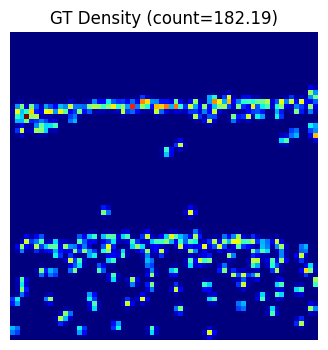

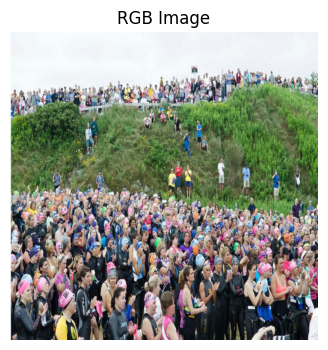

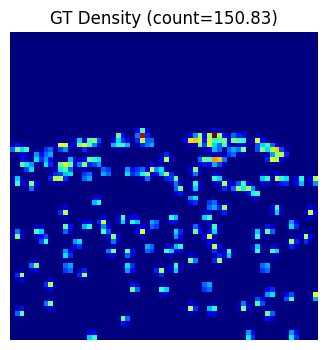

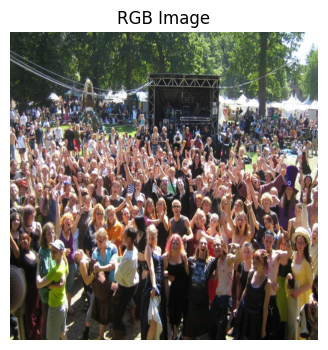

In [40]:
###############################################
# 8) VISUALIZE 4 SAMPLES (FIXED & ROBUST)
###############################################
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_map(sample):
    """
    Safely visualize samples that may be:
    - (img, gt)
    - gt only
    - RGB tensor (3,H,W)
    - density map (1,H,W or H,W)
    """

    # -----------------------------
    # Extract GT safely
    # -----------------------------
    if isinstance(sample, tuple):
        _, gt = sample
    else:
        gt = sample

    # Convert to numpy
    if isinstance(gt, torch.Tensor):
        gt = gt.cpu().numpy()

    # -----------------------------
    # Fix shape for matplotlib
    # -----------------------------
    if gt.ndim == 3 and gt.shape[0] == 3:
        # RGB image: (3,H,W) → (H,W,3)
        gt_vis = np.transpose(gt, (1, 2, 0))
        title = "RGB Image"
    elif gt.ndim == 3 and gt.shape[0] == 1:
        # Density map: (1,H,W) → (H,W)
        gt_vis = gt.squeeze(0)
        title = f"GT Density (count={gt_vis.sum():.2f})"
    elif gt.ndim == 2:
        gt_vis = gt
        title = f"GT Density (count={gt_vis.sum():.2f})"
    else:
        raise ValueError(f"Unsupported GT shape: {gt.shape}")

    # -----------------------------
    # Plot
    # -----------------------------
    plt.figure(figsize=(5,4))
    plt.imshow(gt_vis, cmap="jet" if gt_vis.ndim == 2 else None)
    plt.axis("off")
    plt.title(title)
    plt.show()


# ---- RUN VISUALIZATION FOR 4 SAMPLES ----
num_samples = min(4, len(test_ds))
for i in range(num_samples):
    show_map(test_ds[i])


In [41]:
import os
print(os.getcwd())
import os
print(os.listdir('/kaggle/working'))


e:\DeepVision Crowd Monitor Ai
['checkpoints']
